In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("/kaggle/input/renewable-power-generation-and-weather-conditions/Renewable.csv", parse_dates=["Time"])
df.columns = df.columns.str.strip()
df = df.sort_values("Time")
df.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1


In [11]:
df["hour"] = df["Time"].dt.hour
df["dayofweek"] = df["Time"].dt.dayofweek
df["month"] = df["Time"].dt.month

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


In [12]:
# Rolling features (window=3)
df["GHI_roll3"] = df["GHI"].rolling(window=3).mean()
df["temp_roll3"] = df["temp"].rolling(window=3).mean()
df["wind_roll3"] = df["wind_speed"].rolling(window=3).mean()

# Target lags
df["target_lag_1"] = df["Energy delta[Wh]"].shift(1)
df["target_lag_2"] = df["Energy delta[Wh]"].shift(2)
df["target_lag_3"] = df["Energy delta[Wh]"].shift(3)

# Drop initial rows with NaNs created due to rolling and shifting
df = df.dropna().reset_index(drop=True)


In [13]:
target_col = "Energy delta[Wh]"
feature_cols = [
     "GHI", "temp", "humidity", "wind_speed",
    "GHI_roll3", "temp_roll3", "wind_roll3",
    "target_lag_1", "target_lag_2", "target_lag_3",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
target = np.log1p(df[target_col].values)  # log1p to stabilize scale


In [14]:
def create_windows(X, y, window_size=72):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 72
X_seq, y_seq = create_windows(scaled_features, target, window_size)


In [15]:
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1751270201.152769      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
input_layer = layers.Input(shape=(window_size, X_train.shape[2]))
x = layers.TimeDistributed(layers.Dense(64, activation="relu"))(input_layer)
x = layers.TimeDistributed(layers.Dropout(0.2))(x)
x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(1)(x)

model = keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 72, 16)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 72, 64)         │          1,088 │ input_layer[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 72, 64)         │              0 │ time_distributed[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 72, 64)         │         33,216 │ time_distributed_1[0]… │
│ (MultiHeadAttention)      │                        │                │ time_distributed_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │          8,320 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,945 (199.00 KB)

 Trainable params: 50,945 (199.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("/kaggle/working/best_model.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=200, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/200


I0000 00:00:1751270306.894421     106 service.cc:148] XLA service 0x7a12180cb800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751270306.895241     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751270309.187469     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751270341.973228     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4918/4918 - 118s - 24ms/step - loss: 1.2812 - mae: 0.6548 - val_loss: 1.6369 - val_mae: 0.7754 - learning_rate: 0.0010
Epoch 2/200
4918/4918 - 26s - 5ms/step - loss: 0.8263 - mae: 0.4941 - val_loss: 1.4588 - val_mae: 0.7818 - learning_rate: 0.0010
Epoch 3/200
4918/4918 - 26s - 5ms/step - loss: 0.6935 - mae: 0.4379 - val_loss: 0.9153 - val_mae: 0.5591 - learning_rate: 0.0010
Epoch 4/200
4918/4918 - 26s - 5ms/step - loss: 0.6285 - mae: 0.4054 - val_loss: 1.0161 - val_mae: 0.5618 - learning_rate: 0.0010
Epoch 5/200
4918/4918 - 26s - 5ms/step - loss: 0.5890 - mae: 0.3838 - val_loss: 0.7427 - val_mae: 0.4441 - learning_rate: 0.0010
Epoch 6/200
4918/4918 - 26s - 5ms/step - loss: 0.5492 - mae: 0.3653 - val_loss: 0.7389 - val_mae: 0.4504 - learning_rate: 0.0010
Epoch 7/200
4918/4918 - 26s - 5ms/step - loss: 0.5262 - mae: 0.3557 - val_loss: 0.7251 - val_mae: 0.4795 - learning_rate: 0.0010
Epoch 8/200
4918/4918 - 26s - 5ms/step - loss: 0.5057 - mae: 0.3470 - val_loss: 0.6714 - val_mae: 0.4383 - 

In [22]:
# 🔁 Predict on Training Set
y_pred_train = model.predict(X_train).flatten()
y_true_train = y_train.flatten()

# 📊 Calculate MAE and RMSE
mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

# ✅ Print Results
print(f"✅ Training MAE  : {mae_train:.3f} kW")
print(f"✅ Training RMSE : {rmse_train:.3f} kW")


4918/4918 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
✅ Training MAE  : 0.393 kW
✅ Training RMSE : 0.705 kW


In [19]:
y_pred = model.predict(X_val).flatten()
y_true = y_val.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"✅ Validation MAE  : {mae:.3f} kW")
print(f"✅ Validation RMSE : {rmse:.3f} kW")


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
✅ Validation MAE  : 0.415 kW
✅ Validation RMSE : 0.776 kW


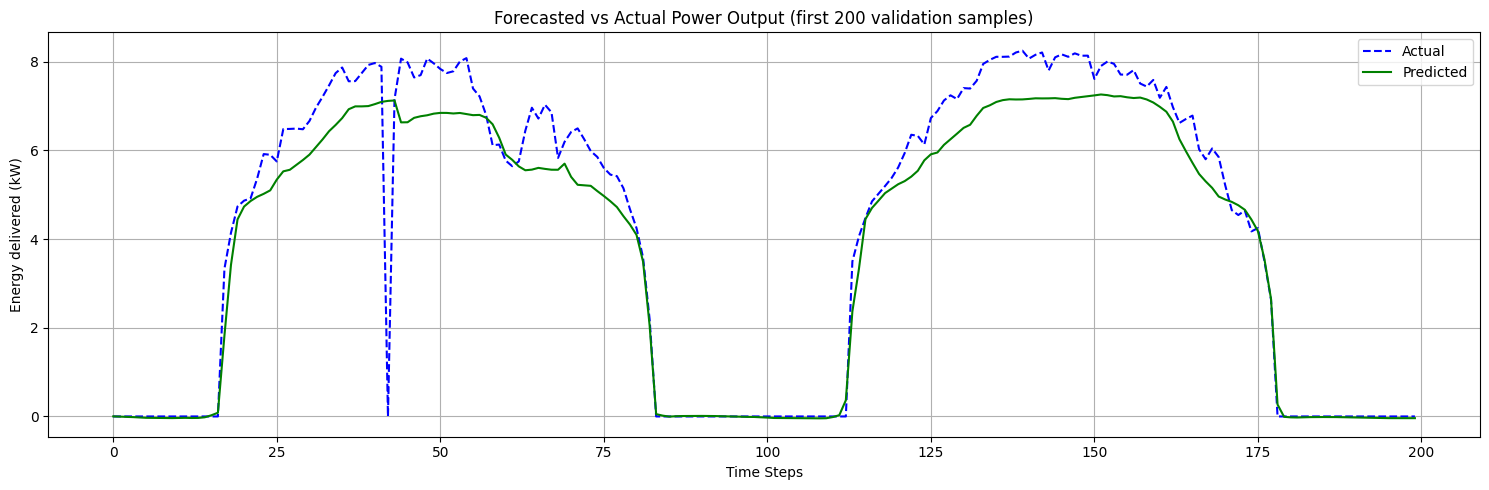

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(y_true[:200], label="Actual", color="blue", linestyle="dashed")
plt.plot(y_pred[:200], label="Predicted", color="green")
plt.title("Forecasted vs Actual Power Output (first 200 validation samples)")
plt.xlabel("Time Steps")
plt.ylabel("Energy delivered (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


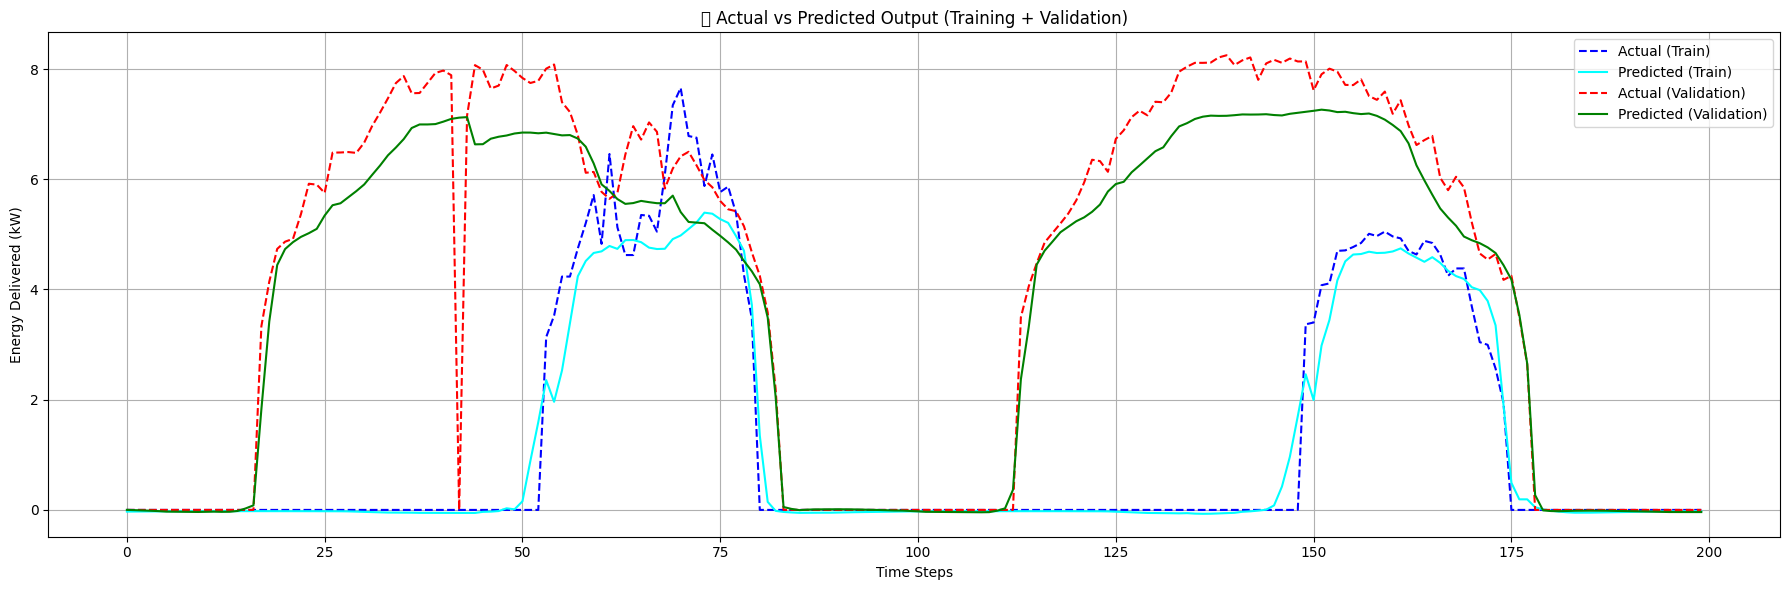

In [23]:
plt.figure(figsize=(18, 6))

# Training Set Plot (first 200 samples)
plt.plot(y_true_train[:200], label="Actual (Train)", color="blue", linestyle="dashed")
plt.plot(y_pred_train[:200], label="Predicted (Train)", color="cyan")

# Validation Set Plot (first 200 samples)
plt.plot(y_true[:200], label="Actual (Validation)", color="red", linestyle="dashed")
plt.plot(y_pred[:200], label="Predicted (Validation)", color="green")

plt.title("Actual vs Predicted Output (Training + Validation)")
plt.xlabel("Time Steps")
plt.ylabel("Energy Delivered (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
